In [2]:
import numpy as np
import matplotlib.pyplot as plt
import importlib.util
import sys
import os
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.collections import PathCollection

from matplotlib.patches import Rectangle
from matplotlib.patches import ConnectionPatch

from scipy.optimize import curve_fit

module_name = "utils_v2"
file_path = "/workspaces/TP3/utils_v2.py"

spec = importlib.util.spec_from_file_location(module_name, file_path)
module = importlib.util.module_from_spec(spec)
sys.modules[module_name] = module
spec.loader.exec_module(module)

# Importer le module
import utils_v2 as u

import pandas as pd

In [3]:
def linear_fit(x, a, b):
    return a * x + b

# Langmuir 1

$p = 3.8e^{-2}$ mbar

$I = 0.029$ A

$f = 74.9$ Hz

In [4]:
#Extract datas

Vs = [[] for _ in range(16)]
Is = [[] for _ in range(16)]

for i in range(1, 17):
    if i < 10:
        j = '0' + str(i)
    else:
        j = str(i)
    data = pd.read_csv(f'/workspaces/TP3/TP_Plasma/Datas/L1/I{j}.CSV', sep=',', decimal='.', header=1, usecols=[1, 2])

    V = data.iloc[:, 0].to_numpy()
    I = data.iloc[:, 1].to_numpy()
    V = V*15
    I = I * 0.5 * 1e-3

    Vs[i - 1].append(V)
    Is[i - 1].append(I)


<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_30523/674120808.py:4: SyntaxWarning: invalid escape sequence '\l'
  ylabel = '$\ln(I_L)$'
/tmp/ipykernel_30523/674120808.py:16: RuntimeWarning: invalid value encountered in log
  ln_I = np.log(I)
/workspaces/TP3/utils_v2.py:346: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend = ax.legend(ncol = ncol, loc = loc)


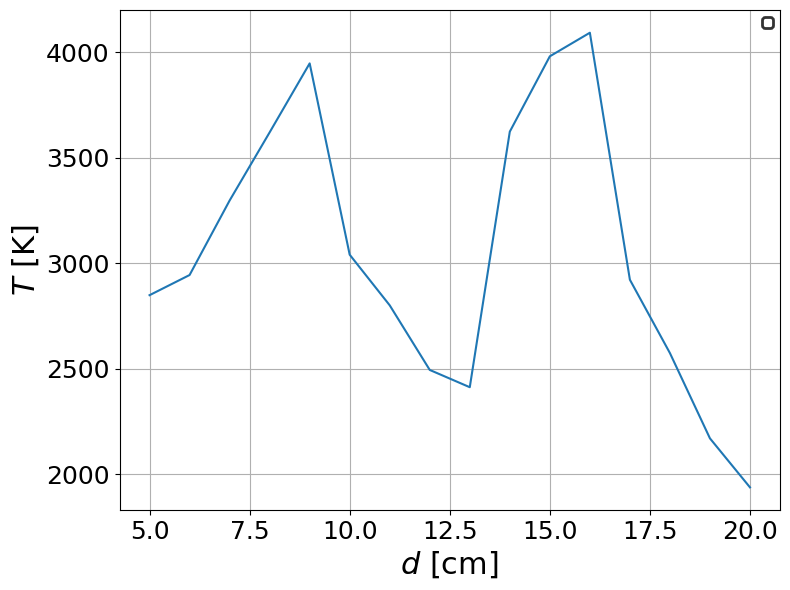

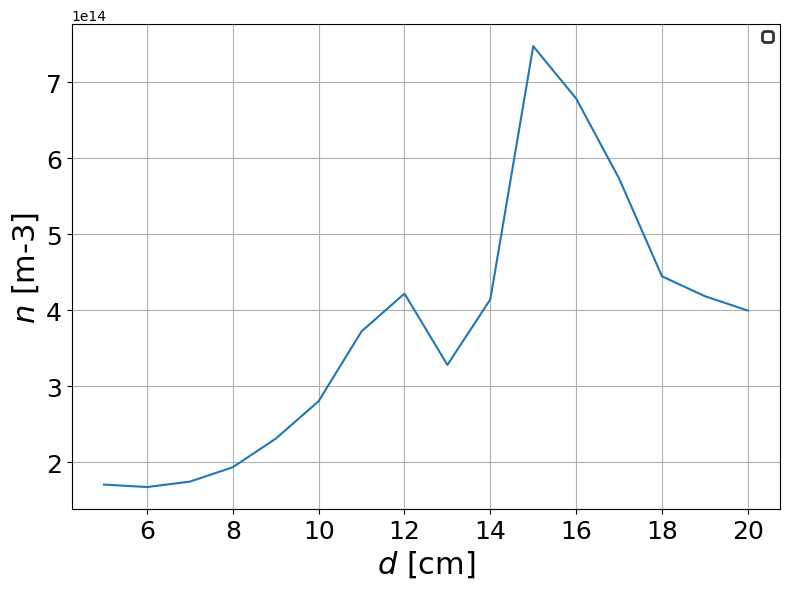

In [5]:
# Plot

xlabel = '$V_L$ [V]'
ylabel = '$\ln(I_L)$'

e = 1.6e-19
me = 9.1e-31
kb = 1.38e-23
A = 9.6e-6
Ts = np.zeros(len(Vs))
ns = np.zeros(len(Vs)) 

for i in range (len(Vs)):
    V = Vs[i][0]
    I = Is[i][0]
    ln_I = np.log(I)

    for idx in range(len(ln_I)):
        if np.isnan(ln_I[idx]):
            ln_I[idx] = ln_I[idx - 1] if idx - 1 >= 0 else ln_I[idx + 1]

    i1 = 11900
    popt1, pcov1 = curve_fit(linear_fit, V[i1-3000:i1], ln_I[i1-3000:i1], p0=[1, 1])

    popt2, pcov2 = curve_fit(linear_fit, V[5600:5700], ln_I[5600:5700], p0=[1, 1])


    V_P = (popt2[1] - popt1[1]) / (popt1[0] - popt2[0])
    ln_I_P = linear_fit(V_P, *popt1)

    T = e / (kb * popt2[0])

    n = 1/(A * e) * np.sqrt(2 * np.pi * me / (kb * T)) * np.exp(linear_fit(V_P, *popt2))

    Ts[i] = T
    ns[i] = n
    
    # ax,fig = u.create_figure_and_apply_format((8,6),xlabel=xlabel, ylabel=ylabel)
    # ax.plot(V[0:i1], ln_I[0:i1], label=f'$d = {i+5} cm$')
    # ax.plot(V, linear_fit(V, *popt1), 'r--')
    # ax.plot(V, linear_fit(V, *popt2), 'r--')

    # ax.set_ylim(-16, -8)

    # u.set_legend_properties(ax)

    # plt.show()

    # print(f'T = {T:.2f} K')
    # print(f'n = {n:.2e} cm-3')

ax,fig = u.create_figure_and_apply_format((8,6),xlabel='$d$ [cm]', ylabel='$T$ [K]')
ax.plot(np.arange(5, 21), Ts)
u.set_legend_properties(ax)
plt.show()

ax,fig = u.create_figure_and_apply_format((8,6),xlabel='$d$ [cm]', ylabel='$n$ [m-3]')
ax.plot(np.arange(5, 21), ns)
u.set_legend_properties(ax)
plt.show()

# Langmuir 2
$p = 4.6e^{-2}$ mbar

$I = 0.03$ A

$f = 74.9$ Hz

In [6]:
#Extract datas

Vs = [[] for _ in range(16)]
Is = [[] for _ in range(16)]

for i in range(1, 17):
    if i < 10:
        j = '0' + str(i)
    else:
        j = str(i)
    data = pd.read_csv(f'/workspaces/TP3/TP_Plasma/Datas/L2/I{j}.CSV', sep=',', decimal='.', header=1, usecols=[1, 2])

    V = data.iloc[:, 0].to_numpy()
    I = data.iloc[:, 1].to_numpy()
    V = V*15
    I = I * 0.5 * 1e-3

    Vs[i - 1].append(V)
    Is[i - 1].append(I)


<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_30523/4177617414.py:4: SyntaxWarning: invalid escape sequence '\l'
  ylabel = '$\ln(I_L)$'
/tmp/ipykernel_30523/4177617414.py:16: RuntimeWarning: invalid value encountered in log
  ln_I = np.log(I)
/workspaces/TP3/utils_v2.py:346: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend = ax.legend(ncol = ncol, loc = loc)


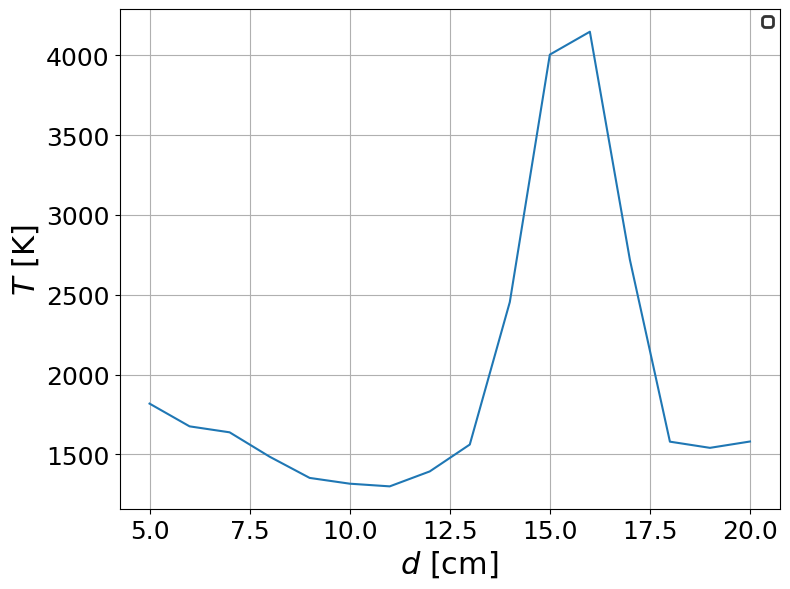

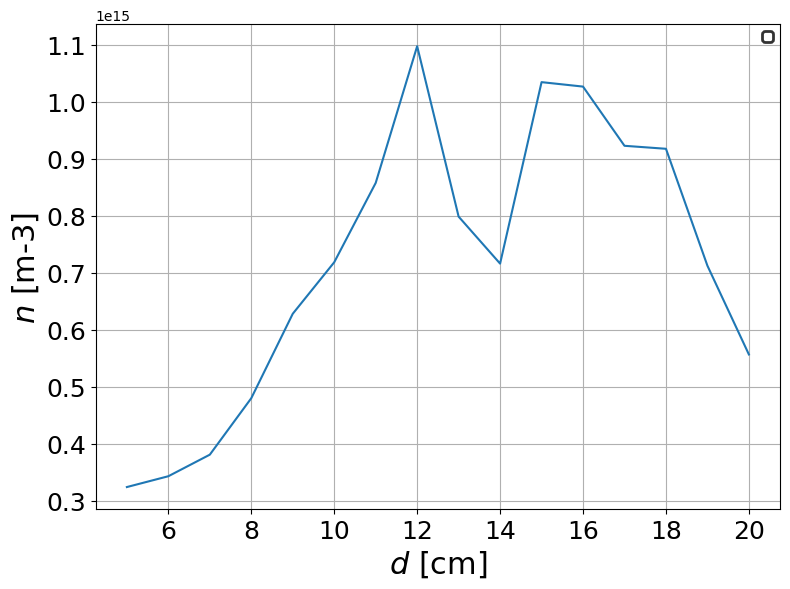

In [7]:
# Plot

xlabel = '$V_L$ [V]'
ylabel = '$\ln(I_L)$'

e = 1.6e-19
me = 9.1e-31
kb = 1.38e-23
A = 9.6e-6
Ts = np.zeros(len(Vs))
ns = np.zeros(len(Vs)) 

for i in range (len(Vs)):
    V = Vs[i][0]
    I = Is[i][0]
    ln_I = np.log(I)

    for idx in range(len(ln_I)):
        if np.isnan(ln_I[idx]):
            ln_I[idx] = ln_I[idx - 1] if idx - 1 >= 0 else ln_I[idx + 1]

    i1 = 12000
    i0 = 24000

    popt1, pcov1 = curve_fit(linear_fit, V[i1-3000:i1], ln_I[i1-3000:i1], p0=[1, 1])

    popt1_1, pcov1_1 = curve_fit(linear_fit, V[i1:i1+3000], ln_I[i1:i1+3000], p0=[1, 1])

    popt2, pcov2 = curve_fit(linear_fit, V[5650:5800], ln_I[5650:5800], p0=[1, 1])

    popt1_moy = (popt1 + popt1_1) / 2
    V_P = (popt2[1] - popt1_moy[1]) / (popt1_moy[0] - popt2[0])
    ln_I_P = linear_fit(V_P, *popt1_moy)

    T = e / (kb * popt2[0])

    n = 1/(A * e) * np.sqrt(2 * np.pi * me / (kb * T)) * np.exp(linear_fit(V_P, *popt2))

    Ts[i] = T
    ns[i] = n
    
    # ax,fig = u.create_figure_and_apply_format((8,6),xlabel=xlabel, ylabel=ylabel)
    # ax.plot(V[0:i0], ln_I[0:i0], label=f'$d = {i+5} cm$')
    # ax.plot(V[0:i1], linear_fit(V[0:i1], *popt1), 'r--')
    # ax.plot(V[i1:i0], linear_fit(V[i1:i0], *popt1_1), 'r--')
    # ax.plot(V[0:i1], linear_fit(V[0:i1], *popt2), 'r--')

    # ax.set_ylim(-16, -8)

    # u.set_legend_properties(ax)

    # plt.show()

    # print(f'T = {T:.2f} K')
    # print(f'n = {n:.2e} cm-3')

ax,fig = u.create_figure_and_apply_format((8,6),xlabel='$d$ [cm]', ylabel='$T$ [K]')
ax.plot(np.arange(5, 21), Ts)
u.set_legend_properties(ax)
plt.show()

ax,fig = u.create_figure_and_apply_format((8,6),xlabel='$d$ [cm]', ylabel='$n$ [m-3]')
ax.plot(np.arange(5, 21), ns)
u.set_legend_properties(ax)
plt.show()

# Langmuir 3
$p = 6.0e^{-2}$ mbar

$I = 0.03$ A

$f = 74.9$ Hz

In [8]:
#Extract datas

Vs = [[] for _ in range(16)]
Is = [[] for _ in range(16)]

for i in range(1, 17):
    if i < 10:
        j = '0' + str(i)
    else:
        j = str(i)
    data = pd.read_csv(f'/workspaces/TP3/TP_Plasma/Datas/L3/I{j}.CSV', sep=',', decimal='.', header=1, usecols=[1, 2])

    V = data.iloc[:, 0].to_numpy()
    I = data.iloc[:, 1].to_numpy()
    V = V*15
    I = I * 0.5 * 1e-3

    Vs[i - 1].append(V)
    Is[i - 1].append(I)


<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_30523/4110262664.py:4: SyntaxWarning: invalid escape sequence '\l'
  ylabel = '$\ln(I_L)$'


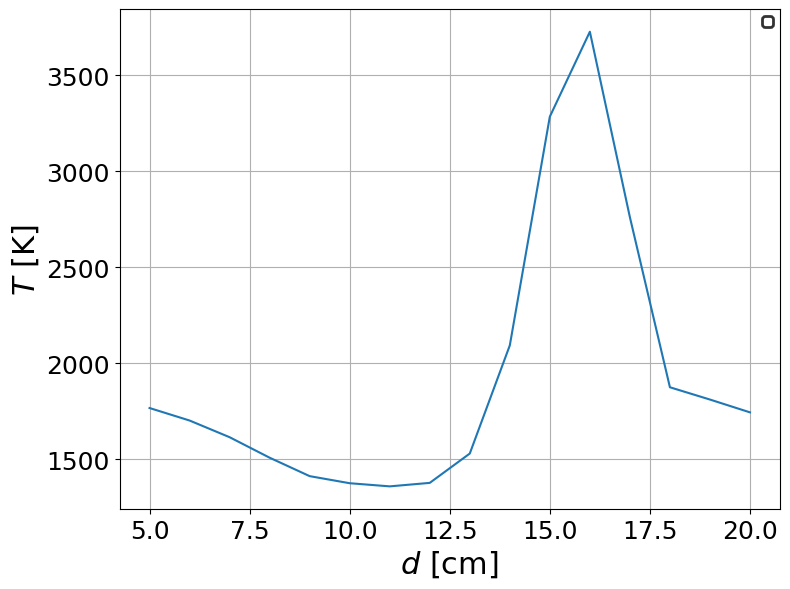

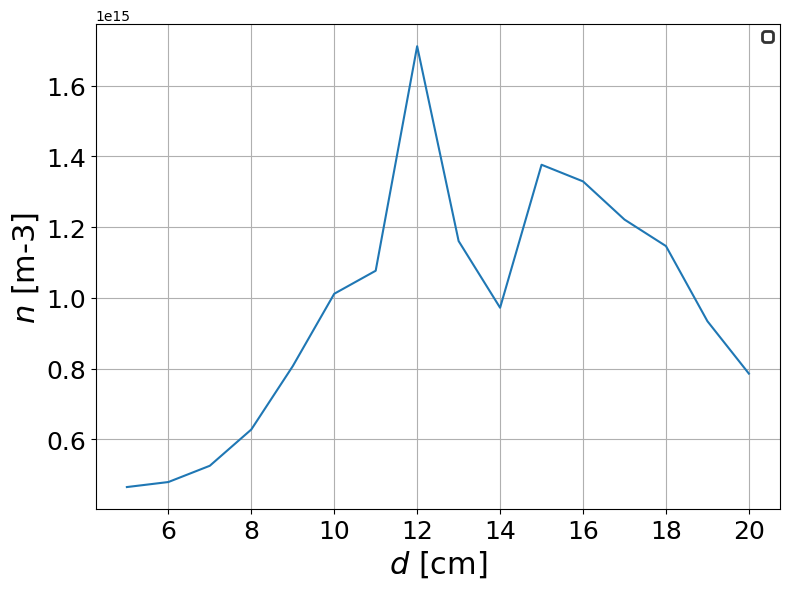

In [15]:
# Plot

xlabel = '$V_L$ [V]'
ylabel = '$\ln(I_L)$'

e = 1.6e-19
me = 9.1e-31
kb = 1.38e-23
A = 9.6e-6
Ts = np.zeros(len(Vs))
ns = np.zeros(len(Vs)) 

for i in range (len(Vs)):
    V = Vs[i][0]
    I = Is[i][0]
    ln_I = np.log(I)

    for idx in range(len(ln_I)):
        if np.isnan(ln_I[idx]):
            ln_I[idx] = ln_I[idx - 1] if idx - 1 >= 0 else ln_I[idx + 1]

    i1 = 12000
    i0 = 24000
    popt1, pcov1 = curve_fit(linear_fit, V[i1-3000:i1], ln_I[i1-3000:i1], p0=[1, 1])

    popt1_1, pcov1_1 = curve_fit(linear_fit, V[i1:i1+3000], ln_I[i1:i1+3000], p0=[1, 1])

    popt2, pcov2 = curve_fit(linear_fit, V[5600:5800], ln_I[5600:5800], p0=[1, 1])


    popt1_moy = (popt1 + popt1_1) / 2
    V_P = (popt2[1] - popt1_moy[1]) / (popt1_moy[0] - popt2[0])
    ln_I_P = linear_fit(V_P, *popt1_moy)

    T = e / (kb * popt2[0])

    n = 1/(A * e) * np.sqrt(2 * np.pi * me / (kb * T)) * np.exp(linear_fit(V_P, *popt2))

    Ts[i] = T
    ns[i] = n
    
    # ax,fig = u.create_figure_and_apply_format((8,6),xlabel=xlabel, ylabel=ylabel)
    # ax.plot(V[0:i0], ln_I[0:i0], label=f'$d = {i+5} cm$')
    # ax.plot(V[0:i1], linear_fit(V[0:i1], *popt1), 'r--')
    # ax.plot(V[i1:i0], linear_fit(V[i1:i0], *popt1_1), 'r--')
    # ax.plot(V[0:i1], linear_fit(V[0:i1], *popt2), 'r--')

    # ax.set_ylim(-16, -8)

    # u.set_legend_properties(ax)

    # plt.show()

    # print(f'T = {T:.2f} K')
    # print(f'n = {n:.2e} cm-3')

ax,fig = u.create_figure_and_apply_format((8,6),xlabel='$d$ [cm]', ylabel='$T$ [K]')
ax.plot(np.arange(5, 21), Ts)
u.set_legend_properties(ax)
plt.show()

ax,fig = u.create_figure_and_apply_format((8,6),xlabel='$d$ [cm]', ylabel='$n$ [m-3]')
ax.plot(np.arange(5, 21), ns)
u.set_legend_properties(ax)
plt.show()

## Langmuir 4
$p = 4.1e^{-2}$ mbar

$I = 0.03$ A

$f = 144.6$ Hz


In [ ]:
#Extract datas

Vs = [[] for _ in range(16)]
Is = [[] for _ in range(16)]

for i in range(1, 17):
    if i < 10:
        j = '0' + str(i)
    else:
        j = str(i)
    data = pd.read_csv(f'/workspaces/TP3/TP_Plasma/Datas/L4/I{j}.CSV', sep=',', decimal='.', header=1, usecols=[1, 2])

    V = data.iloc[:, 0].to_numpy()
    I = data.iloc[:, 1].to_numpy()
    V = V*15
    I = I * 0.5 * 1e-3

    Vs[i - 1].append(V)
    Is[i - 1].append(I)


<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_30523/320990260.py:4: SyntaxWarning: invalid escape sequence '\l'
  ylabel = '$\ln(I_L)$'


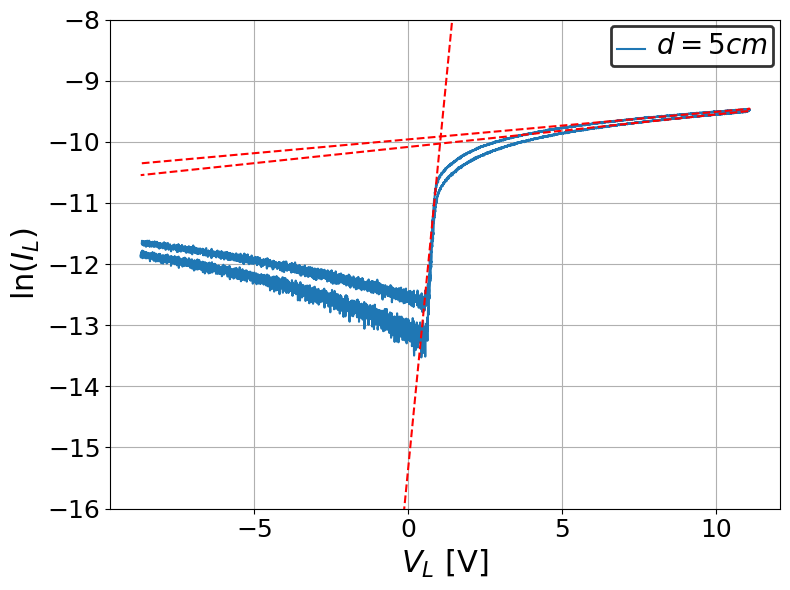

T = 2258.43 K
n = 4.12e+14 cm-3


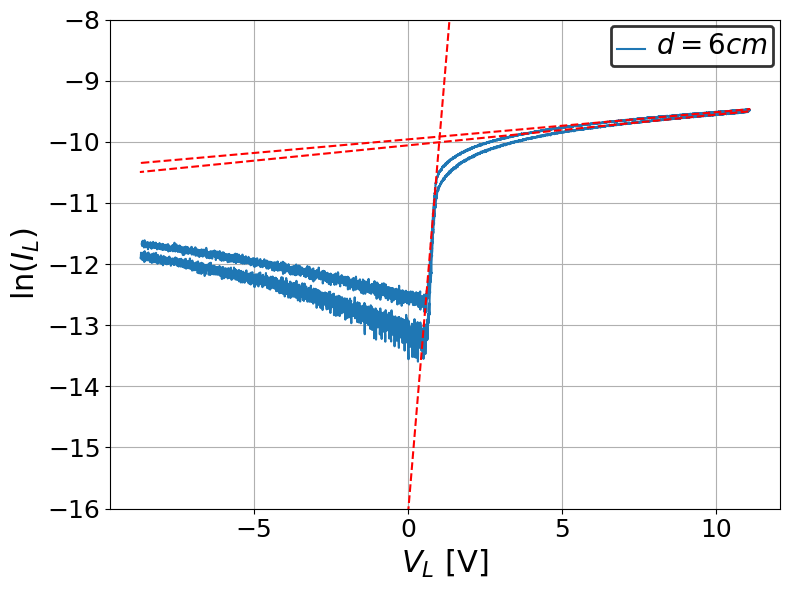

T = 1932.70 K
n = 4.50e+14 cm-3


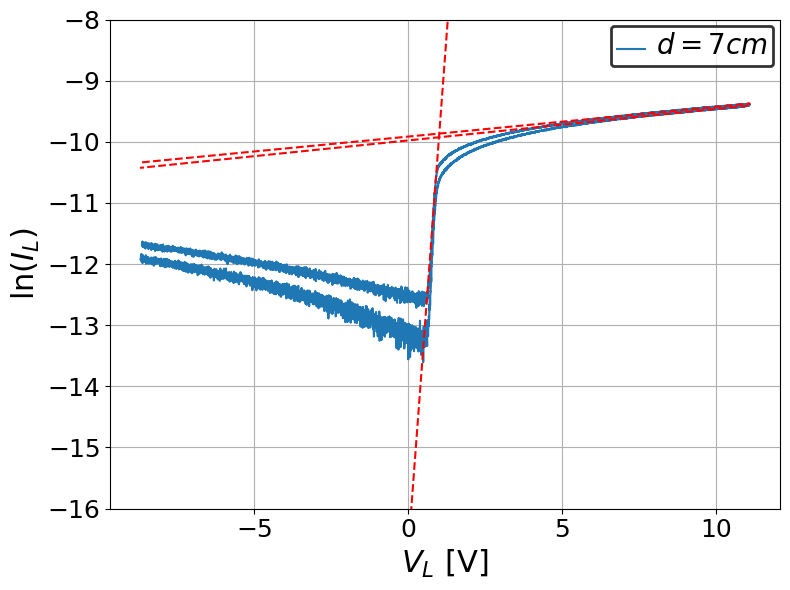

T = 1718.34 K
n = 5.09e+14 cm-3


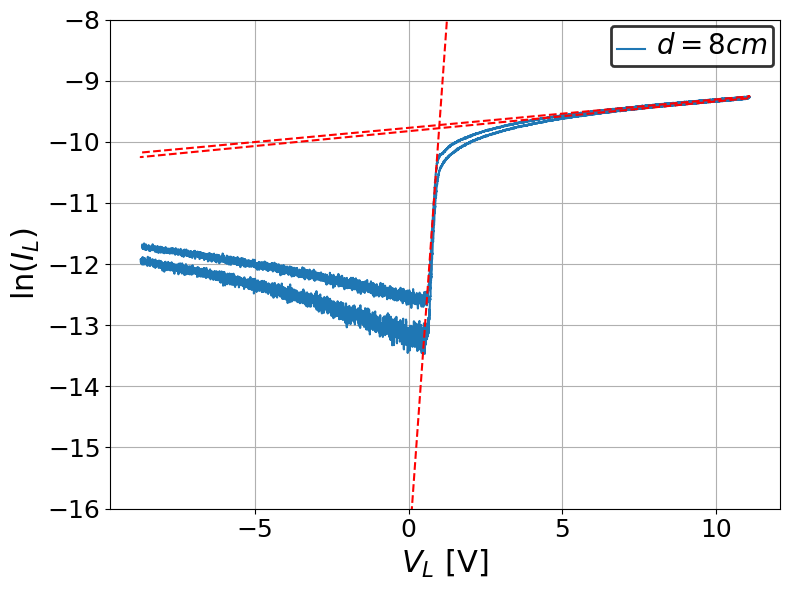

T = 1652.70 K
n = 6.00e+14 cm-3


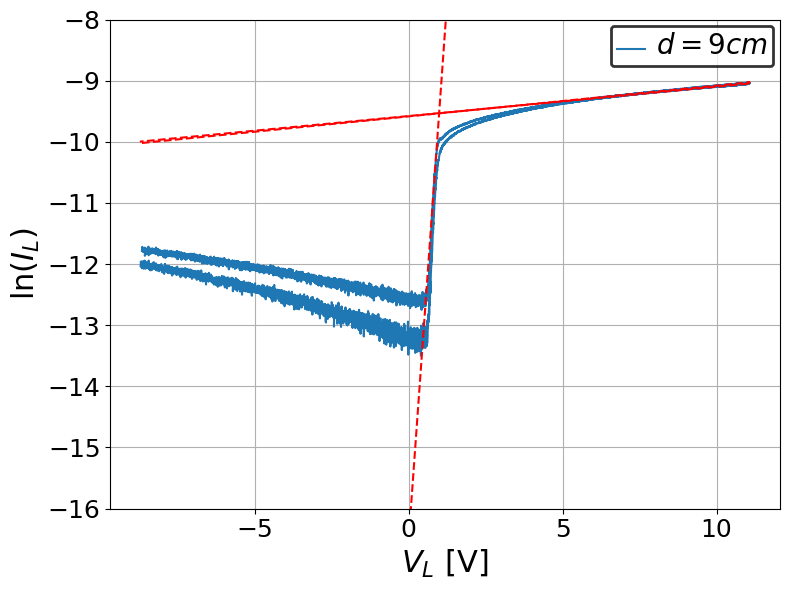

T = 1644.75 K
n = 7.48e+14 cm-3


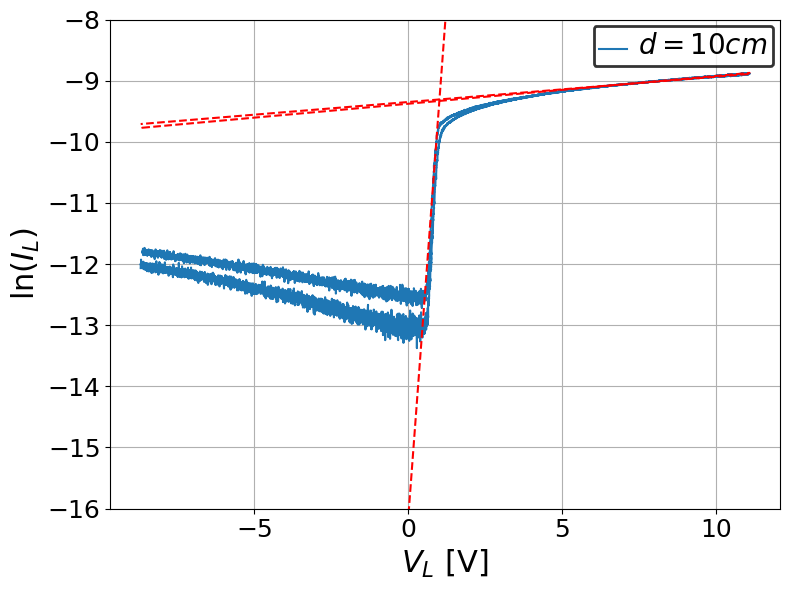

T = 1717.83 K
n = 9.06e+14 cm-3


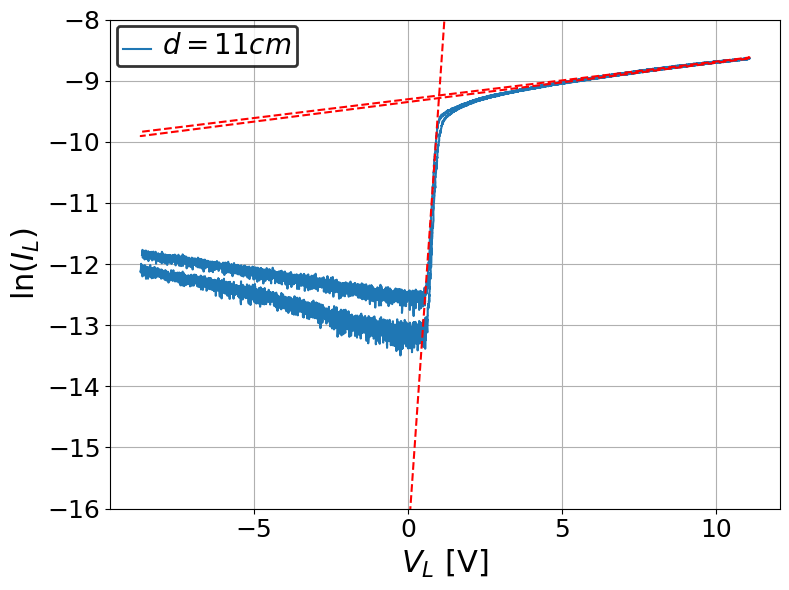

T = 1604.27 K
n = 9.92e+14 cm-3


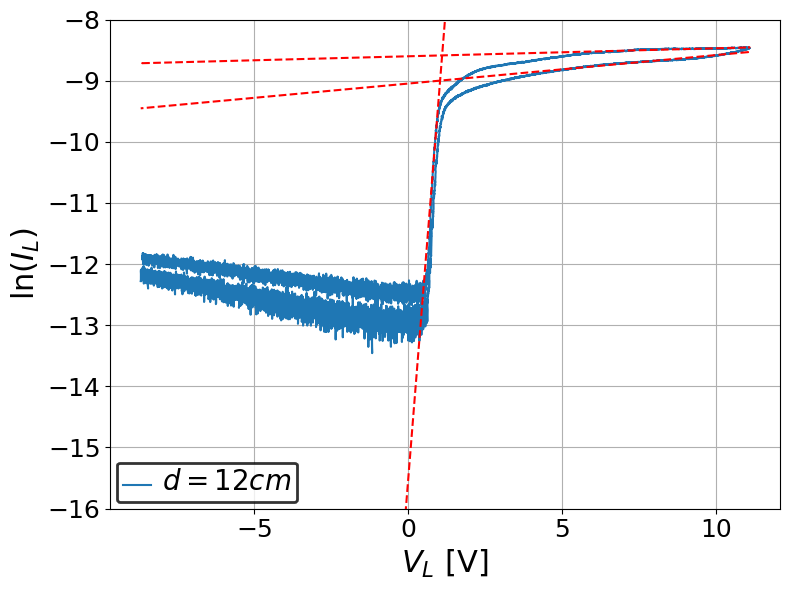

T = 1842.22 K
n = 1.48e+15 cm-3


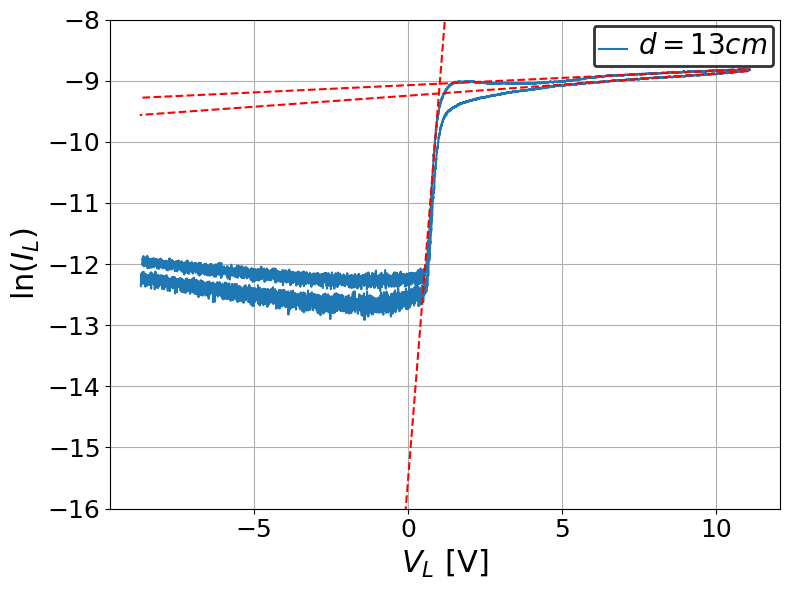

T = 1842.28 K
n = 1.06e+15 cm-3


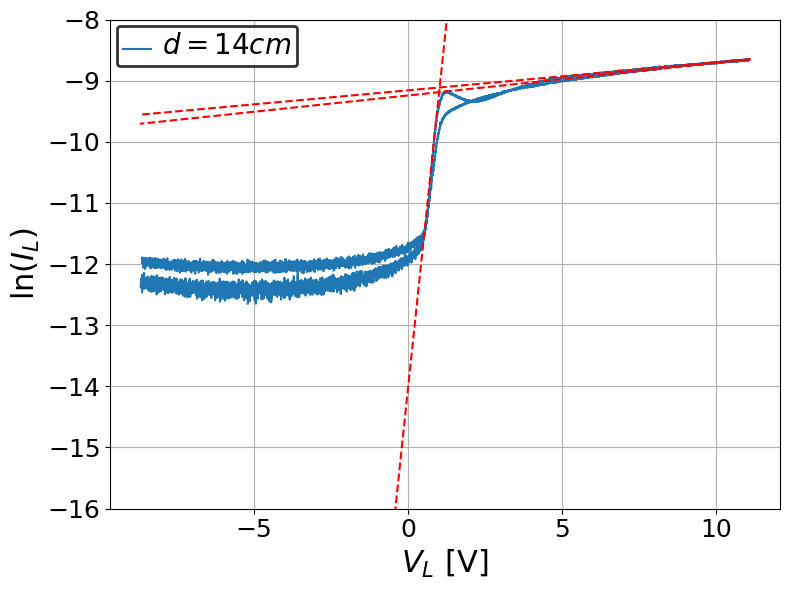

T = 2420.19 K
n = 9.05e+14 cm-3


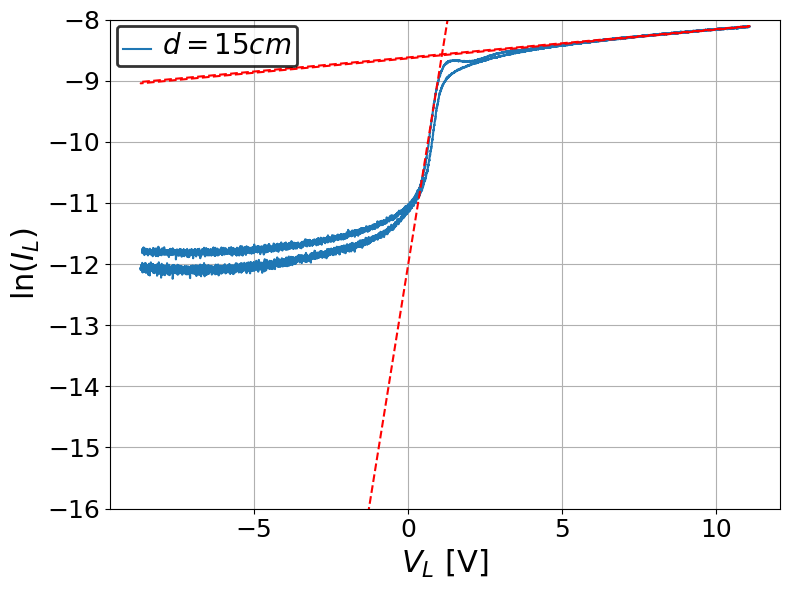

T = 3704.04 K
n = 1.30e+15 cm-3


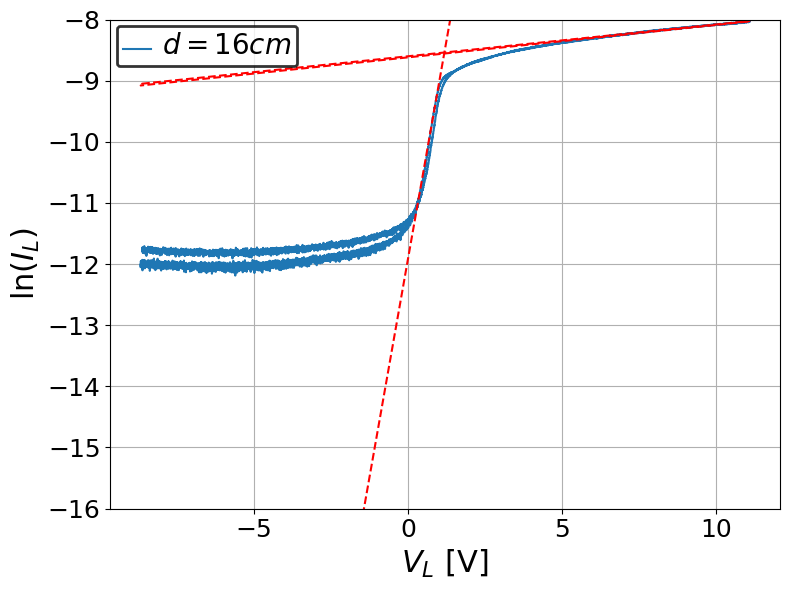

T = 4059.64 K
n = 1.28e+15 cm-3


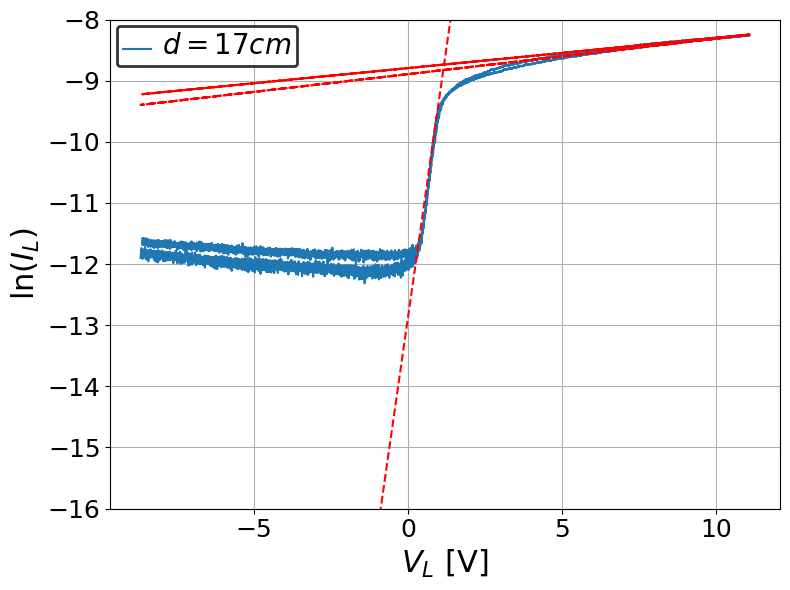

T = 3286.79 K
n = 1.12e+15 cm-3


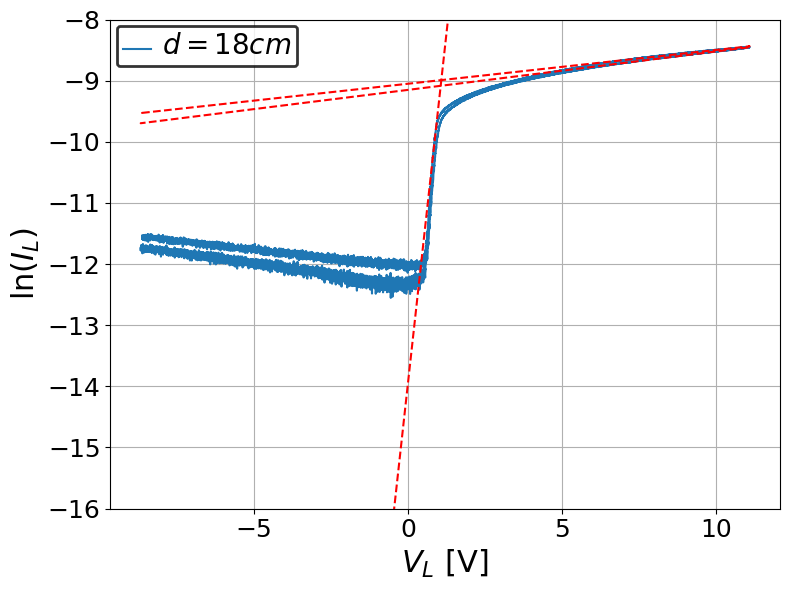

T = 2534.06 K
n = 9.89e+14 cm-3


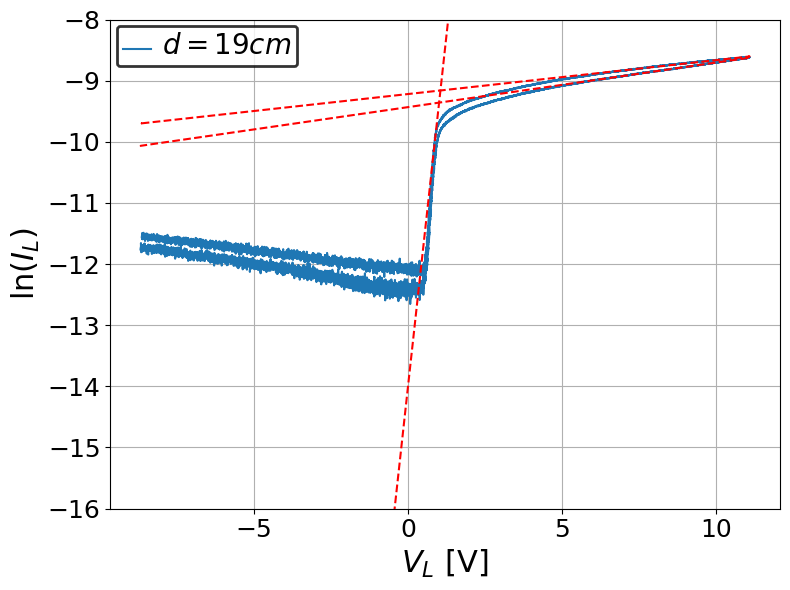

T = 2522.57 K
n = 7.94e+14 cm-3


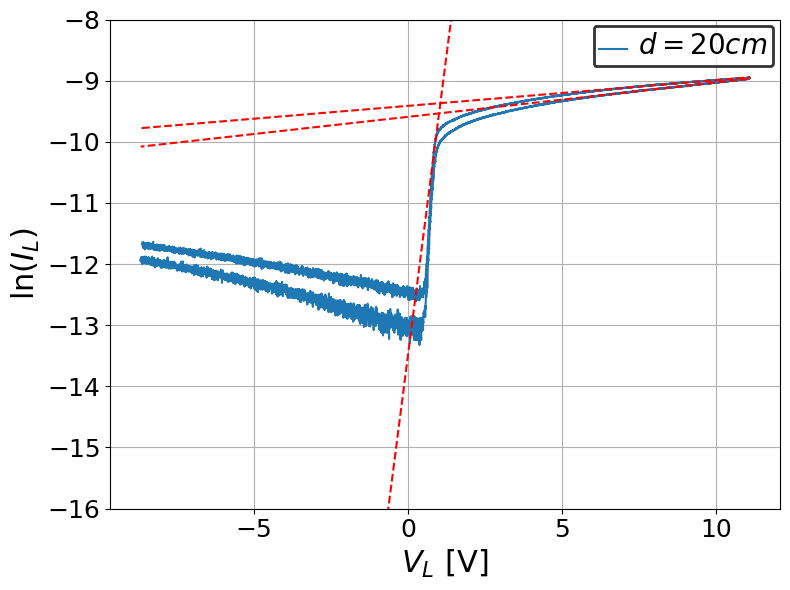

T = 2957.27 K
n = 6.05e+14 cm-3


/workspaces/TP3/utils_v2.py:346: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend = ax.legend(ncol = ncol, loc = loc)


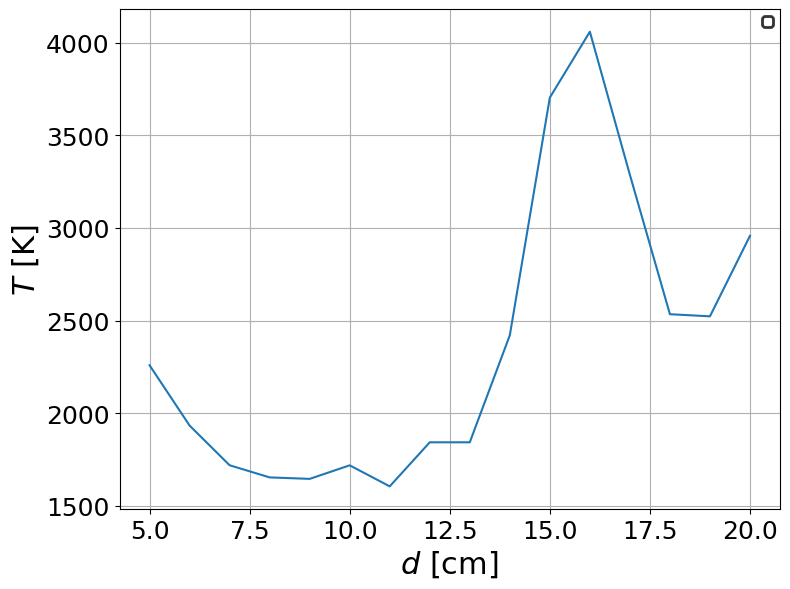

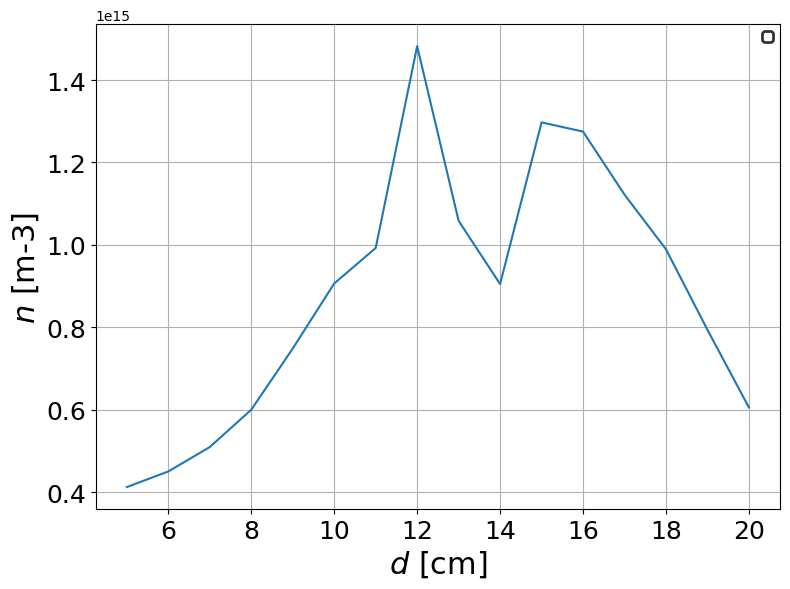

In [11]:
# Plot

xlabel = '$V_L$ [V]'
ylabel = '$\ln(I_L)$'

e = 1.6e-19
me = 9.1e-31
kb = 1.38e-23
A = 9.6e-6
Ts = np.zeros(len(Vs))
ns = np.zeros(len(Vs)) 

for i in range (len(Vs)):
    V = Vs[i][0]
    I = Is[i][0]
    ln_I = np.log(I)

    for idx in range(len(ln_I)):
        if np.isnan(ln_I[idx]):
            ln_I[idx] = ln_I[idx - 1] if idx - 1 >= 0 else ln_I[idx + 1]

    i1 = 12000
    i0 = 24000

    popt1, pcov1 = curve_fit(linear_fit, V[i1-3000:i1], ln_I[i1-3000:i1], p0=[1, 1])

    popt1_1, pcov1_1 = curve_fit(linear_fit, V[i1:i1+3000], ln_I[i1:i1+3000], p0=[1, 1])

    popt2, pcov2 = curve_fit(linear_fit, V[5700:5800], ln_I[5700:5800], p0=[1, 1])

    popt1_moy = (popt1 + popt1_1) / 2
    V_P = (popt2[1] - popt1_moy[1]) / (popt1_moy[0] - popt2[0])
    ln_I_P = linear_fit(V_P, *popt1_moy)

    T = e / (kb * popt2[0])

    n = 1/(A * e) * np.sqrt(2 * np.pi * me / (kb * T)) * np.exp(linear_fit(V_P, *popt2))

    Ts[i] = T
    ns[i] = n
    
    ax,fig = u.create_figure_and_apply_format((8,6),xlabel=xlabel, ylabel=ylabel)
    ax.plot(V[0:i0], ln_I[0:i0], label=f'$d = {i+5} cm$')
    ax.plot(V[0:i1], linear_fit(V[0:i1], *popt1), 'r--')
    ax.plot(V[i1:i0], linear_fit(V[i1:i0], *popt1_1), 'r--')
    ax.plot(V[0:i1], linear_fit(V[0:i1], *popt2), 'r--')

    ax.set_ylim(-16, -8)

    u.set_legend_properties(ax)

    plt.show()

    print(f'T = {T:.2f} K')
    print(f'n = {n:.2e} cm-3')

ax,fig = u.create_figure_and_apply_format((8,6),xlabel='$d$ [cm]', ylabel='$T$ [K]')
ax.plot(np.arange(5, 21), Ts)
u.set_legend_properties(ax)
plt.show()

ax,fig = u.create_figure_and_apply_format((8,6),xlabel='$d$ [cm]', ylabel='$n$ [m-3]')
ax.plot(np.arange(5, 21), ns)
u.set_legend_properties(ax)
plt.show()